# Artifact removal with MNE
This notebook imports the artifact data obtained by [convolving](03_Convolve_EEG.ipynb) the clean [(BETA dataset)](http://bci.med.tsinghua.edu.cn/download.html) dataset with the artifact [Temple University)](https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml#i_rsyn) dataset.

The `.npz` files imported in this notebook have the following variables:
- `clean` = clean EEG data (i.e., with no artifacts).
- `conv` = convoluted data (i.e., clean + artifact).
- `chans` = channel names of the data. Each name is a column in the clean an conv variables.
- `srate` = Sampling rate of the data [Hz].

In [28]:
# Needed when working with MNE plots
%matplotlib qt

# Import libraries
import os
import mne
import numpy as np
import torch as tr
from scipy import signal
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

# Settings 
file_name = 'conv_eye_data.npz' # Name of file to work with [str]
ssvep = 0   # SSVEP block to analyze
            # 0 = 10 Hz
            # 1 = 12 Hz
            # 2 = 15Hz

# Import file
# - Directories
par_dir = os.getcwd()               # Parent directory
data_dir = '\\Data\\Convolved\\'    # Data directory

# - Import and separated data
data = np.load(par_dir+data_dir+file_name, allow_pickle=True)
clean_data = data['clean']
clean_chans = data['clean_chans']
conv_data = data['conv']
chans = data['chans']   # Array with channel names
srate = data['srate']   # Sampling rate [Hz]

## MNE ICA tutorial
Tutorial found [here](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html) 

1. Create mne data from numpy array. Tutorial [here](https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html)

In [34]:
# Create metadata
n_channels = len(chans)
sampling_freq = srate  # Sampling frequency [Hz]
info = mne.create_info(chans.tolist(), srate, ch_types='eeg')

# Create and visualize raw data 
raw_data = mne.io.RawArray(conv_data[ssvep].T, info)    # Convoluted data
raw_data.plot_psd(fmax=35, dB=False)

# Filter raw data - HPF fc = 1Hz
filt_data = raw_data.copy().filter(l_freq=1, h_freq=None)

# Enable CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')  

# Define and apply ICA
n_components = 15   # Number of components for ICA
ica = ICA(n_components=n_components, max_iter='auto', random_state=97)
ica.fit(filt_data)
ica

Creating RawArray with float64 data, n_channels=15, n_times=750
    Range : 0 ... 749 =      0.000 ...     2.996 secs
Ready.


TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [32]:
# ica.plot_sources(raw_data)
ica.plot_components()

RuntimeError: No digitization points found.

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 15 PCA components
Effective window size : 3.000 (s)


C:\Users\danie\AppData\Local\Temp/ipykernel_23032/1535274022.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  recons_data.plot_psd(fmax=35, dB=False)


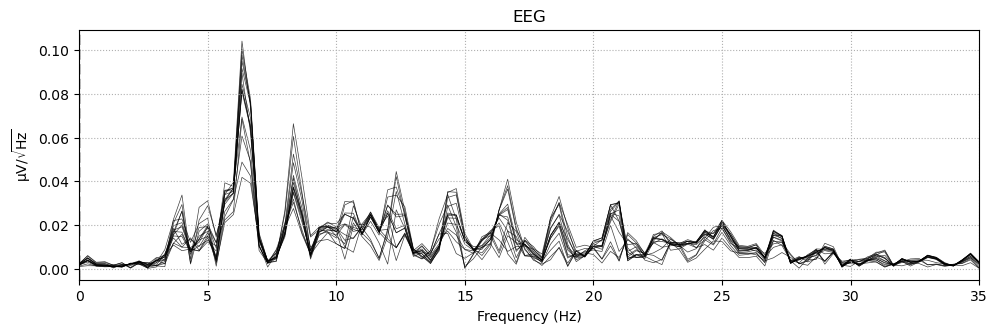

In [ ]:
# ica.plot_overlay(raw_data, exclude=[0])
recons_data = raw_data.copy()

ica.exclude = [0]
ica.apply(recons_data)

recons_data.plot_psd(fmax=35, dB=False)